In [1]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from sklearn.decomposition import PCA,SparsePCA
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import align_trials, select_trials
from ephysvibe.trials.spikes import firing_rate
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
from ephysvibe.task import task_constants
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
seed=2024

In [2]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

In [3]:
if platform.system() == "Linux":
    basepath = (
        "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/"
    )
elif platform.system() == "Windows":
    basepath = 'D:/data/'#"C:/Users/camil/Documents/int/"

In [4]:
session = '2022-12-05_10-51-52'
areas=['pfc','v4']
subject='Riesling'
time_before=200

In [5]:
units_info = {'v4':{},'pfc':{}}
for area in areas:
    neu_path = basepath + "session_struct/" + area + "/neurons/*neu.h5"
    path_list = np.array(glob.glob(neu_path))
    mask=[]
    for path in path_list:
        mask.append(session == path.replace("\\", "/").rsplit("/")[-1].rsplit("_" + subject)[0])
    path_list=path_list[mask]
    units_info[area]['paths']=path_list
    

In [6]:
def get_unit(path,time_before):
    neu_data = NeuronData.from_python_hdf5(path)

    # get spike matrices in and out conditions
    sp_in, mask_in = align_trials.get_align_tr(
        neu_data, select_block=1, select_pos=1, time_before=time_before,event="sample_on"
    )
    if np.mean(sp_in[:,200:1000]) < 5/1000: 
        return None
    sp_samples = select_trials.get_sp_by_sample(sp_in[:,:time_before+1000], neu_data.sample_id[mask_in], samples=[0,11,15,55,51])
    sp_samples['path']=path
    sp_samples['n_type']=neu_data.cluster_group
    return sp_samples

In [7]:
area_info={}
for area in areas:
    path_list = units_info[area]['paths']

    info = Parallel(n_jobs=-1)(
        delayed(get_unit)(path_list[i],time_before)for i in tqdm(range(len(path_list)))
    )
    area_info[area] = info

100%|██████████| 73/73 [00:21<00:00,  3.39it/s]


In [8]:
for area in areas:
    paths,n_type=[],[]
    sp11=[]
    sp15=[]
    sp51=[]
    sp55=[]
    sp0=[]
    for i_info in area_info[area]:
        if i_info is not None:
            paths.append(i_info['path'])
            sp11.append(i_info['11'])
            sp15.append(i_info['15'])
            sp51.append(i_info['51'])
            sp55.append(i_info['55'])
            sp0.append(i_info['0'])
            n_type.append(i_info['n_type'])
    units_info[area]['paths'] = np.array(paths)
    units_info[area]['11'] = np.array(sp11)
    units_info[area]['15'] = np.array(sp15)
    units_info[area]['51'] = np.array(sp51)
    units_info[area]['55'] = np.array(sp55)
    units_info[area]['0'] = np.array(sp0)
    units_info[area]['n_type'] = np.array(n_type)

In [9]:
def moving_average(data: np.ndarray, win: int, step: int = 1) -> np.ndarray:
    d_shape = data.shape
    count = 0
    win=int(np.floor(win/2))
    if len(d_shape) == 3:
        d_avg = np.zeros((d_shape[0], d_shape[1], int(np.floor(d_shape[2] / step))))
        for i_step in np.arange(0, d_shape[2] - step, step):
            st_win = 0 if i_step-win <0 else i_step-win
            d_avg[:, :, count] = np.mean(data[:, :, st_win : i_step + win], axis=2)
            count += 1
    if len(d_shape) == 2:
        d_avg = np.zeros((d_shape[0], int(np.floor(d_shape[1] / step))))
        for i_step in np.arange(0, d_shape[1] - step, step):
            st_win = 0 if i_step-win <0 else i_step-win
            d_avg[:, count] = np.mean(data[:, st_win : i_step + win], axis=1)
            count += 1
    if len(d_shape) == 1:
        d_avg = np.zeros((int(np.floor(d_shape[0] / step))))
        for i_step in np.arange(0, d_shape[0] - step, step):
            d_avg[count] = np.mean(data[i_step : i_step + win], axis=0)
            count += 1
    return d_avg

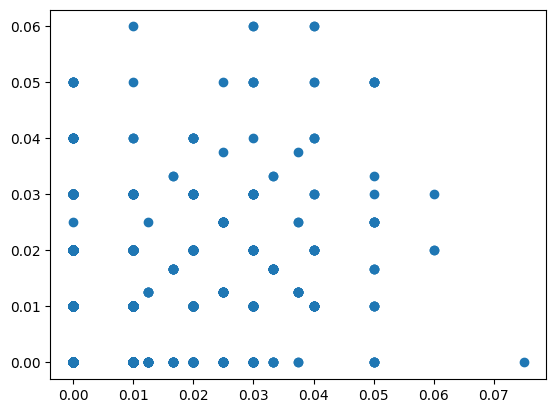

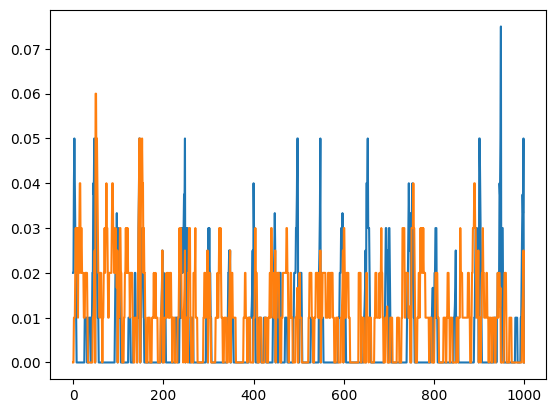

In [31]:
#typemask = units_info['pfc']['n_type']=='good'
n1=units_info['pfc']['11'][1]
#typemask = units_info['v4']['n_type']=='good'
n2=units_info['v4']['11'][2]
n1_avg=firing_rate.moving_average(data=n1[:,time_before:], win=100, step=20)
n2_avg=firing_rate.moving_average(data=n2[:,time_before:], win=100, step=20)
plt.subplots()
plt.scatter(n1_avg,n2_avg)
n1_avg.shape
plt.subplots()
plt.plot(n1_avg.reshape(-1)[:1000])
plt.plot(n2_avg.reshape(-1)[:1000])

In [14]:
x=units_info['v4']['11']
y=units_info['pfc']['11']
step=20
x=moving_average(data=x, win=100, step=step)[:,:,int((time_before+30)/step):int((time_before+500)/step)]
y=moving_average(data=y, win=100, step=step)[:,:,int((time_before+30)/step):int((time_before+500)/step)]
x=(x.reshape(x.shape[0],-1).T)#/np.max(x,axis=1)
y=(y.reshape(y.shape[0],-1).T)#/np.max(y,axis=1)
ss = StandardScaler(with_mean=True, with_std=False)
x=ss.fit_transform(x)
ss = StandardScaler(with_mean=True, with_std=False)
y=ss.fit_transform(y)
print(x.shape)
print(y.shape)

(1224, 34)
(1224, 30)


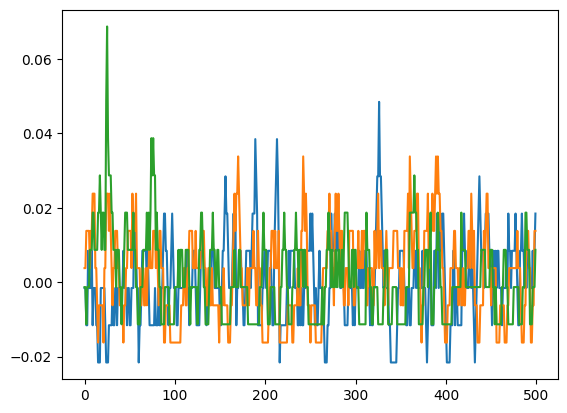

In [15]:
for i in range(3):
    plt.plot(x[:500,i])

0.23360746140475713

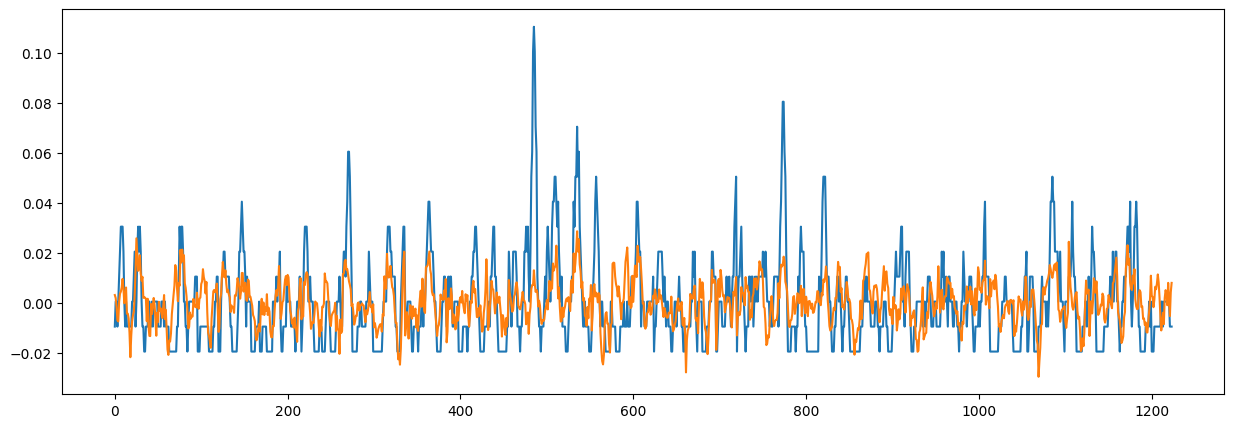

In [16]:
i_n=0
lr_m = LinearRegression( fit_intercept=True,n_jobs=-1)
lr_m.fit(x,y)
y_pred = lr_m.predict(x)
plt.subplots(figsize=(15,5))
plt.plot(y[:1600,i_n])
plt.plot(y_pred[:1600,i_n])
#print(1-metrics.mean_squared_error(y_pred,y))
lr_m.score(x,y)

In [17]:
def get_cv_scores(model, X, y, seed=None,cv=5):
    kfold = KFold(n_splits=cv, shuffle=True,random_state=seed)  # Create KFold object
    train_scores, test_scores = [], []
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)  # Train the model on the training fold
        train_scores.append((model.score(X_train,y_train)))  # Record training score
        test_scores.append((model.score(X_test,y_test)))  # Record testing score
    return train_scores,test_scores

In [18]:
def get_lambda_cv_scores(model, X, y, lambdas, seed=None,cv=5):
    """Compute the mean training and testing scores for each regularization parameter (lambda).
    Args:
        model (sklearn):  model to use.
        X (numpy.ndarray): The input features.
        y (numpy.ndarray): The target values.
        lambdas (list): A list of regularization parameters (lambda values) to try.
        cv (int): The number of folds for cross-validation.
    """
    train_scores, test_scores = [], []
    for lam in lambdas:
        model.set_params(alpha=lam)  # Set regularization parameter
        i_train_scores,i_test_scores = get_cv_scores(model, X, y, cv=cv,seed=seed)
        train_scores.append(i_train_scores)
        test_scores.append(i_test_scores )
    return train_scores,test_scores

In [19]:
rng = np.random.RandomState(seed)
linear_model = LinearRegression( fit_intercept=True,n_jobs=-1)
kf = KFold(n_splits=10, shuffle=True, random_state=seed)
linear_scores = cross_val_score(linear_model, x, y, cv=kf,scoring='r2')

In [20]:
print(linear_scores)
print(np.mean(linear_scores))

[0.16049102 0.18465291 0.15758656 0.16834637 0.16894942 0.18306681
 0.19939821 0.17812306 0.18058598 0.19999105]
0.17811913925381004


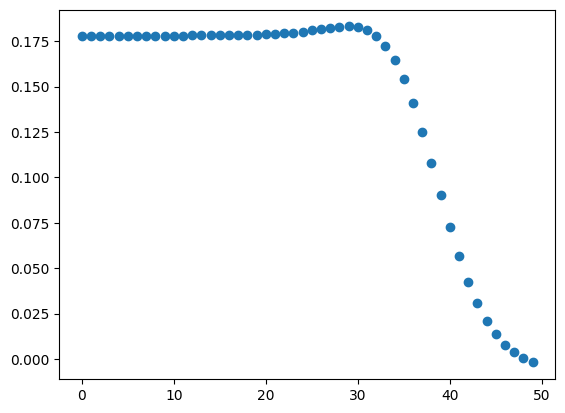

In [21]:
lams = np.logspace(0, 50, num=50, base=1.4, endpoint=False)* 1e-6
#lams = [0.001, 0.01, 0.1, 1.0, 10.0,100,1000,10000,100000,1000000,10000000,100000000,1000000000,100000000000]
all_scores=[]
for lam in lams:
    rng = np.random.RandomState(seed)
    ridge_model = Ridge(alpha=lam,fit_intercept=True)
    kf = KFold(n_splits=10, shuffle=True, random_state=seed)
    ridge_scores = cross_val_score(ridge_model, x, y, cv=kf,n_jobs=-1,scoring='r2')
    all_scores.append(ridge_scores)
#all_scores=-np.array(all_scores)
plt.scatter(range(len(lams)),np.mean(all_scores,axis=1))
arg = np.argmax(np.mean(all_scores,axis=1))
#plt.scatter(lams[arg],np.mean(all_scores,axis=1)[arg])
#plt.scatter(0,np.mean(-linear_scores))

## With my functions

In [22]:
linear_model = LinearRegression( fit_intercept=True,n_jobs=-1)
train_scores,test_scores=get_cv_scores(linear_model, x, y, seed=seed,cv=10)
print((train_scores))
print((test_scores))
mean_train_score = np.mean(train_scores)
print(mean_train_score)
mean_test_score = np.mean(test_scores)
print(mean_test_score)

[0.23764789013421847, 0.23490327342500386, 0.23871899013411918, 0.23682484459701433, 0.23662585814867712, 0.23573220124345706, 0.23377550375247905, 0.23602768072995112, 0.23475320874323252, 0.23446514136869834]
[0.1604910186069811, 0.184652907215398, 0.15758656177445243, 0.1683463678706359, 0.16894942201232027, 0.1830668090875357, 0.1993982117137188, 0.17812306317203183, 0.18058597833173815, 0.19999105275328827]
0.23594745922768506
0.17811913925381004


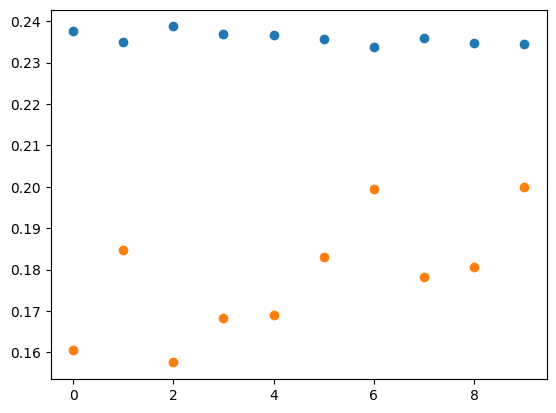

In [23]:
plt.scatter(range(10),train_scores)
plt.scatter(range(10),test_scores)

In [24]:
lams = np.logspace(0, 40, num=100, base=1.4, endpoint=False)* 1e-6
# lams = [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0,100]
# lams = [0.0001, 0.0005,0.001, 0.002, 0.003, 0.004, 0.007, 0.01, 0.03, 0.04, 0.05]
ridge_model = Ridge(fit_intercept=True)
train_scores,test_scores=get_lambda_cv_scores(ridge_model, x, y, lams, seed=seed,cv=10)

0.016161714386003712

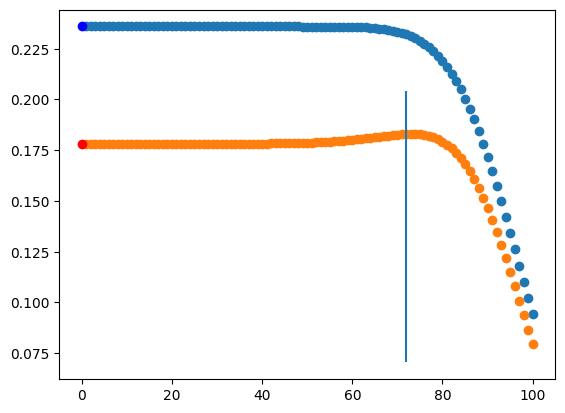

In [25]:

plt.scatter(range(1,len(lams)+1),np.mean(train_scores,axis=1))
plt.scatter([0],[mean_train_score],color='b')
#plt.scatter(range(1,len(lams)+1),np.mean(train_scores,axis=1)-np.std(train_scores,axis=1),'b--')
plt.scatter(range(1,len(lams)+1),np.mean(test_scores,axis=1))
#plt.scatter(range(1,len(lams)+1),np.mean(test_scores,axis=1)+np.std(test_scores,axis=1),'g--')
plt.scatter([0],[mean_test_score],color='r')
im=np.argmax(np.mean(test_scores,axis=1))
plt.vlines(im,np.min(test_scores),np.max(test_scores))
lams[im]

### Correlation

In [26]:
corr_matrix = np.corrcoef(n19,n20).round(decimals=3)[0:size,size:]

NameError: name 'n19' is not defined